In [1]:
# Bloco 1: Imports e Configurações Iniciais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from joblib import dump

# Ajuste opcional de estilo para gráficos (pode remover se não desejar)
sns.set()

In [2]:
# Bloco 2: Carregamento do Dataset

# URL do dataset (Pima Indians Diabetes Database)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'

# Definição dos nomes das colunas
column_names = [
    'Pregnancies', 'Glucose', 'BloodPressure',
    'SkinThickness', 'Insulin', 'BMI',
    'DiabetesPedigreeFunction', 'Age', 'Outcome'
]

# Leitura do dataset
df = pd.read_csv(url, header=None, names=column_names)

# Visualização das 5 primeiras linhas
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Bloco 3: Tratamento de Valores Ausentes

# Colunas em que o valor 0 pode indicar ausência de dado
columns_with_zeros = [
    'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
]

# Substitui 0 por NaN nessas colunas
for col in columns_with_zeros:
    df[col] = df[col].replace(0, np.nan)

# Verificação de valores ausentes
print("Contagem de valores ausentes (NaN):")
print(df.isnull().sum())


Contagem de valores ausentes (NaN):
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


Descrição estatística do dataset:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  763.000000     733.000000     541.000000  394.000000   
mean      3.845052  121.686763      72.405184      29.153420  155.548223   
std       3.369578   30.535641      12.382158      10.476982  118.775855   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.000000      64.000000      22.000000   76.250000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  141.000000      80.000000      36.000000  190.000000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  757.000000                768.000000  768.000000  768.000000  
mean    32.457464                  0.471876   33.240885    0.348958  
std      6.924988                  0.331329   11.760232    0.476951  
m

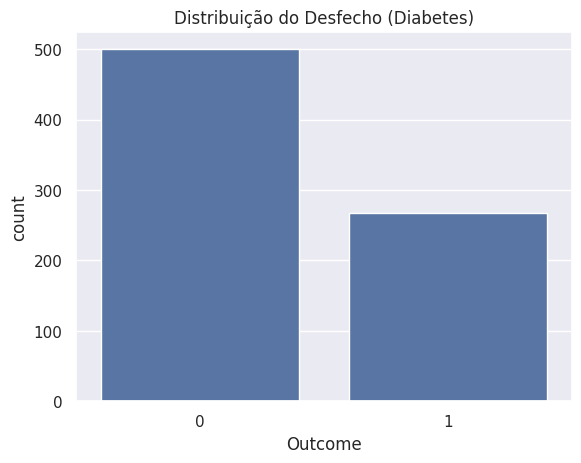

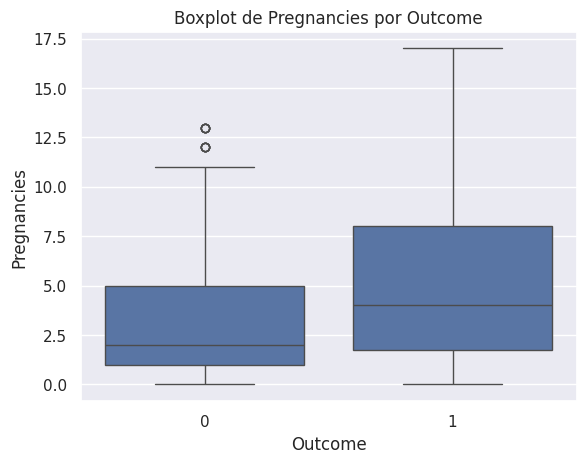

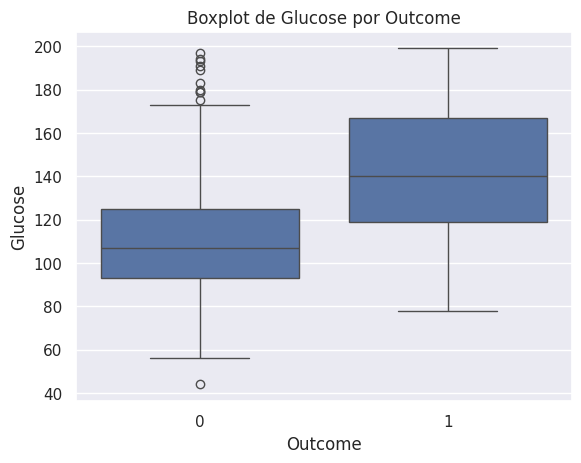

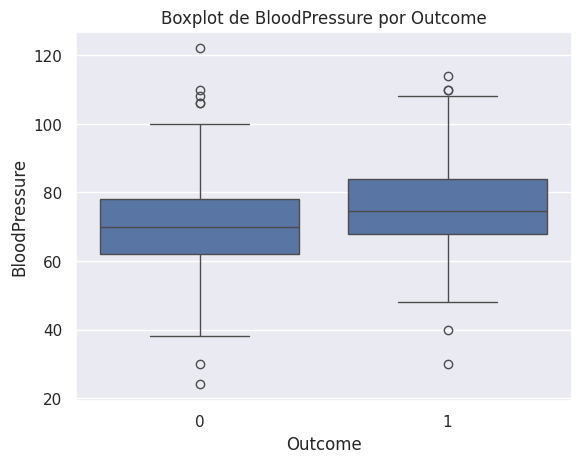

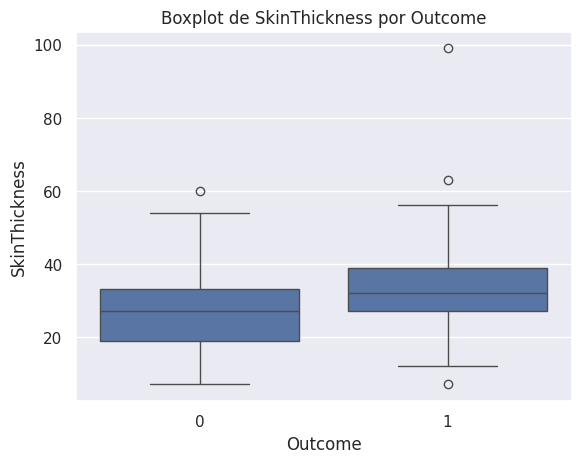

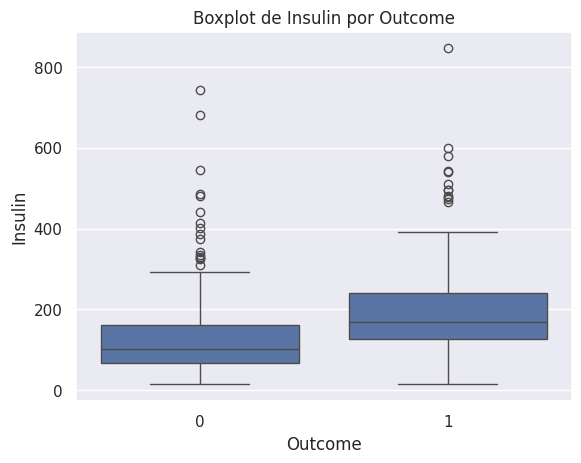

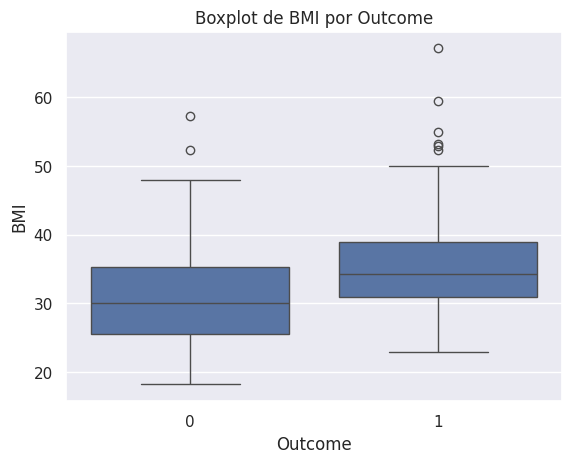

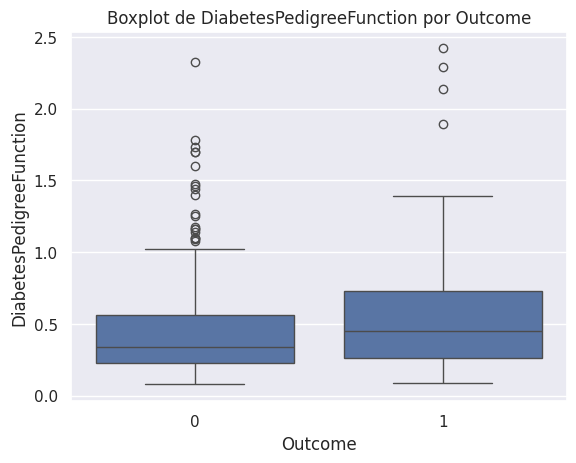

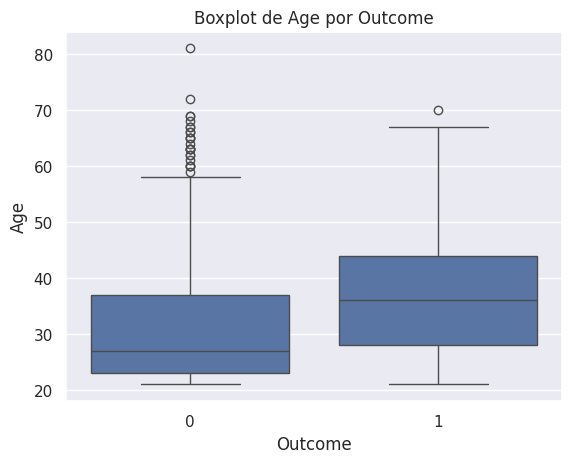

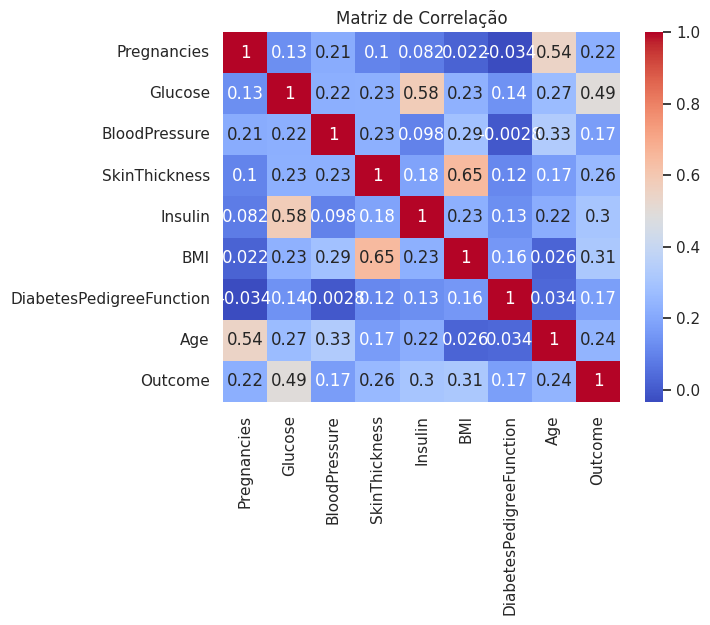

In [4]:
# Bloco 4: Análise Exploratória de Dados (EDA)

# Estatísticas descritivas
print("Descrição estatística do dataset:")
print(df.describe())

# Distribuição da variável alvo (Outcome)
sns.countplot(x='Outcome', data=df)
plt.title('Distribuição do Desfecho (Diabetes)')
plt.show()

# Boxplots para cada feature por Outcome, ignorando NaNs
for col in df.drop('Outcome', axis=1).columns:
    sns.boxplot(x='Outcome', y=col, data=df.dropna(subset=[col]))
    plt.title(f'Boxplot de {col} por Outcome')
    plt.show()

# Matriz de correlação
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


In [5]:
# Bloco 5: Separação em Features (X) e Target (y)

X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Divisão inicial: 70% treino/validação e 30% teste
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Divisão da parte de treino/validação em 50%/50%, resultando em 15%/15% do total
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.50, random_state=42
)

# Verificando o tamanho dos conjuntos
print("Tamanho Treino: ", X_train.shape, y_train.shape)
print("Tamanho Validação: ", X_val.shape, y_val.shape)
print("Tamanho Teste: ", X_test.shape, y_test.shape)


Tamanho Treino:  (268, 8) (268,)
Tamanho Validação:  (269, 8) (269,)
Tamanho Teste:  (231, 8) (231,)


In [6]:
# Bloco 6: Imputação e Padronização dos Dados

# 6.1. Imputação (mean)
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)

X_train_imp = imputer.transform(X_train)
X_val_imp = imputer.transform(X_val)
X_test_imp = imputer.transform(X_test)

# Salvando o imputer
dump(imputer, 'imputer.joblib')

# 6.2. Escalonamento (StandardScaler)
scaler = StandardScaler()
scaler.fit(X_train_imp)

X_train_scaled = scaler.transform(X_train_imp)
X_val_scaled = scaler.transform(X_val_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Salvando o scaler
dump(scaler, 'scaler.joblib')


['scaler.joblib']

In [7]:
# Bloco 7: Construção e Treinamento do Modelo MLP

model = Sequential()
# Camada de entrada + primeira camada oculta (12 neurônios, ativação ReLU)
model.add(Dense(12, input_dim=X_train_scaled.shape[1], activation='relu'))
# Camada de saída (1 neurônio, ativação Sigmoid)
model.add(Dense(1, activation='sigmoid'))

# Compilando o modelo
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# EarlyStopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Treinando o modelo
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.5213 - loss: 0.7126 - val_accuracy: 0.5428 - val_loss: 0.7250
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5369 - loss: 0.7040 - val_accuracy: 0.5836 - val_loss: 0.6996
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5990 - loss: 0.6701 - val_accuracy: 0.6283 - val_loss: 0.6775
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6341 - loss: 0.6336 - val_accuracy: 0.6617 - val_loss: 0.6569
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6530 - loss: 0.6187 - val_accuracy: 0.6766 - val_loss: 0.6384
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6787 - loss: 0.5912 - val_accuracy: 0.6766 - val_loss: 0.6214
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6941 - loss: 0.5852 - val_accuracy: 0.6803 - val_loss: 0.6067
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6844 - loss: 0.5755 - val_accuracy: 0.6914 - val_loss

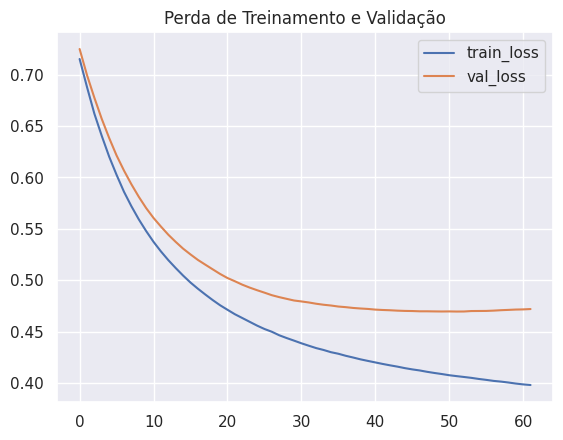

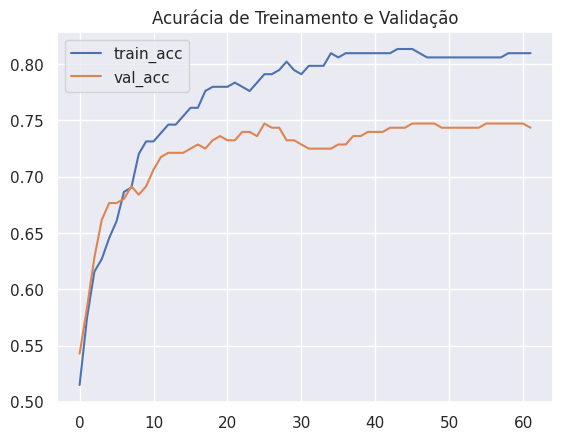

In [8]:
# Bloco 8: Curvas de Aprendizado (Loss e Accuracy)

# Visualizando a curva de perda
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Perda de Treinamento e Validação')
plt.legend()
plt.show()

# Visualizando a curva de acurácia
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Acurácia de Treinamento e Validação')
plt.legend()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7702 - loss: 0.4908
Loss no Teste: 0.5094473361968994
Acurácia no Teste: 0.7662337422370911
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


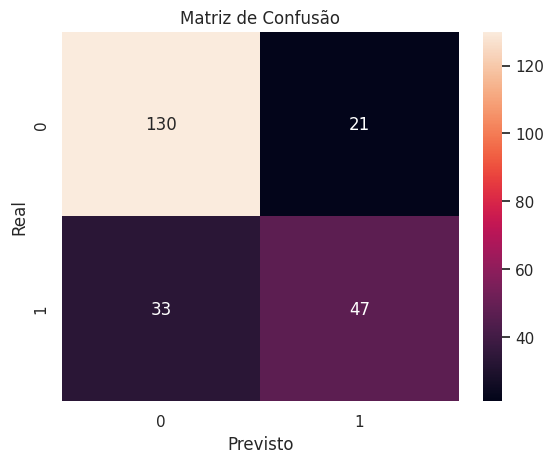

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       151
           1       0.69      0.59      0.64        80

    accuracy                           0.77       231
   macro avg       0.74      0.72      0.73       231
weighted avg       0.76      0.77      0.76       231



In [9]:
# Bloco 9: Avaliação no Conjunto de Teste

loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Loss no Teste: {loss}")
print(f"Acurácia no Teste: {accuracy}")

# Predições
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


In [10]:
# Bloco 10: Salvando o Modelo

model.save('diabetes_mlp.h5')
